<a href="https://colab.research.google.com/github/michaeljunokas/FCRBM/blob/testing_MNIST/FCRBM_MNIST_Test_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ensure the libraries are installed
!pip install tensorflow numpy

In [3]:
import tensorflow as tf
import numpy as np
from fcrbm_utilities import FCRBM

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Place operations on a specific device
# This will force the GPU to be used if it's available.
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Set TensorFlow to use a specific GPU device.
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    print("GPU is being used for training. ✅")
  except RuntimeError as e:
    # Visible devices must be set at program startup
    print(e)
else:
  print("No GPU detected, training on CPU. ⚠️")

GPU is being used for training. ✅


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Flatten the images from (28, 28) to a vector of 784 and normalize
# The RBM expects a flattened vector, not a 2D image
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0

# One-hot encode the labels
# There are 10 classes (0-9) so the style dimension will be 10
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)


v_data = tf.constant(x_train, dtype=tf.float32)
y_data = tf.constant(y_train_one_hot, dtype=tf.float32)
u_data = tf.zeros_like(v_data, dtype=tf.float32)

# Print the shapes to verify
print("MNIST data successfully loaded and preprocessed!")
print(f"Visible data (flattened images) shape: {v_data.shape}")
print(f"History data (zero-filled) shape: {u_data.shape}")
print(f"Style data (one-hot vectors) shape: {y_data.shape}")

MNIST data successfully loaded and preprocessed!
Visible data (flattened images) shape: (60000, 784)
History data (zero-filled) shape: (60000, 784)
Style data (one-hot vectors) shape: (60000, 10)


In [27]:
# The visible dimension is the size of the flattened image (28 * 28)
visible_dim = 784

# The hidden dimension can be tuned, but 100 is a good starting point
hidden_dim = 100

# The style dimension is the number of classes (0-9)
style_dim = 10

# The history dimension matches the visible dimension
history_dim = visible_dim

# Set your training parameters
learning_rate = 0.00001 # A small learning rate is still crucial
epochs = 50
batch_size = 600

In [32]:
# Instantiate the FCRBM with the new parameters
fcrbm = FCRBM(
    visible_dim=visible_dim,
    hidden_dim=hidden_dim,
    style_dim=style_dim,
    history_dim=visible_dim,
    k=1
)

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [33]:
# Create a repeatable dataset
dataset = tf.data.Dataset.from_tensor_slices((v_data, u_data, y_data)).shuffle(buffer_size=60000).batch(batch_size).repeat()

# Use prefetch to overlap data preprocessing with model training.
# `tf.data.AUTOTUNE` automatically tunes the number of elements to prefetch.
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Set the number of steps per epoch
num_total_samples = v_data.shape[0]
steps_per_epoch = num_total_samples // batch_size

# Training loop
for epoch in range(epochs):
    epoch_loss = 0
    # The dataset is now a fast iterator.
    for v_batch, u_batch, y_batch in dataset.take(steps_per_epoch):
        loss = fcrbm.train_step(v_batch, u_batch, y_batch, optimizer)
        epoch_loss += loss.numpy()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / steps_per_epoch:.4f}")

Epoch 1/50, Loss: 0.1255
Epoch 2/50, Loss: 0.1417
Epoch 3/50, Loss: 0.1571
Epoch 4/50, Loss: 0.1696
Epoch 5/50, Loss: 0.1789
Epoch 6/50, Loss: 0.1851
Epoch 7/50, Loss: 0.1889
Epoch 8/50, Loss: 0.1910
Epoch 9/50, Loss: 0.1915
Epoch 10/50, Loss: 0.1911
Epoch 11/50, Loss: 0.1901
Epoch 12/50, Loss: 0.1887
Epoch 13/50, Loss: 0.1871
Epoch 14/50, Loss: 0.1851
Epoch 15/50, Loss: 0.1833
Epoch 16/50, Loss: 0.1813
Epoch 17/50, Loss: 0.1793
Epoch 18/50, Loss: 0.1773
Epoch 19/50, Loss: 0.1757
Epoch 20/50, Loss: 0.1737
Epoch 21/50, Loss: 0.1721
Epoch 22/50, Loss: 0.1702
Epoch 23/50, Loss: 0.1688
Epoch 24/50, Loss: 0.1671
Epoch 25/50, Loss: 0.1659
Epoch 26/50, Loss: 0.1642
Epoch 27/50, Loss: 0.1630
Epoch 28/50, Loss: 0.1617
Epoch 29/50, Loss: 0.1603
Epoch 30/50, Loss: 0.1592
Epoch 31/50, Loss: 0.1581
Epoch 32/50, Loss: 0.1573
Epoch 33/50, Loss: 0.1564
Epoch 34/50, Loss: 0.1555
Epoch 35/50, Loss: 0.1546
Epoch 36/50, Loss: 0.1538
Epoch 37/50, Loss: 0.1530
Epoch 38/50, Loss: 0.1523
Epoch 39/50, Loss: 0.

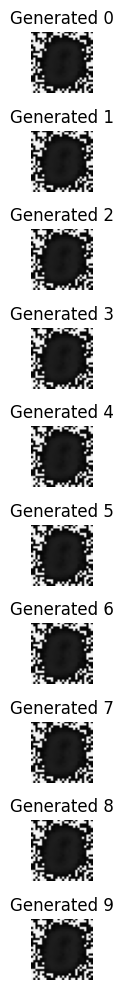

In [15]:
import matplotlib.pyplot as plt

# Assuming your FCRBM model has already been trained

# Define the parameters for the generation
num_digits = 10
visible_dim = 784
style_dim = 10
num_samples_per_digit = 1

# Create a figure to display the generated digits
fig, axes = plt.subplots(num_digits, num_samples_per_digit, figsize=(2, 10))

# Generate one image for each digit (0-9)
for digit in range(num_digits):
    # 1. Prepare the input tensors for a single sample
    # Initialize the visible layer with random noise
    initial_image = tf.random.normal(shape=(1, visible_dim), mean=0, stddev=1, dtype=tf.float32)

    # Create the one-hot encoded style vector for the current digit
    y_input = tf.keras.utils.to_categorical([digit], num_classes=style_dim)
    y_input = tf.constant(y_input, dtype=tf.float32)

    # The history layer is all zeros for MNIST
    u_input = tf.zeros(shape=(1, visible_dim), dtype=tf.float32)

    # 2. Run the Gibbs sampling inference
    # We use a large number of steps (e.g., 5000) to ensure a stable output
    ### generated_image = fcrbm.gibbs_sampling_inference(fcrbm, initial_image, u_input, y_input, steps=1000)

    generated_image = fcrbm.gibbs_sampling_inference(initial_image, u_input, y_input, steps=5000)
    # 3. Reshape the flattened vector back into a 28x28 image
    generated_image = tf.reshape(generated_image, (28, 28))

    # 4. Display the generated image
    ax = axes[digit]
    ax.imshow(generated_image.numpy(), cmap='gray')
    ax.set_title(f'Generated {digit}')
    ax.axis('off')

plt.tight_layout()
plt.show()